In [1]:
import sys
sys.path.append("scripts/")
import numpy as np
from gridmap import*
from robot import*
from scipy.stats import expon, norm, uniform

In [8]:
def occupancyToColor(occupancy):
    return "#"+format(int(255*(1-occupancy)), '02x')*3

class IdealSensor():
    def __init__(self, world, sensing_range=3):
        self.world = world
        self.sensing_range = []
        for i in range(-sensing_range, sensing_range):
            for j in range(-sensing_range, sensing_range):
                if np.sqrt(i**2 + j**2) > sensing_range or (i==0 and j==0):
                    continue
                self.sensing_range.append(np.array([i, j]))
    
    def sense(self, index):
        obstacle_grids = []
        for sensing_grid in self.sensing_range:
            u = index + sensing_grid
            if self.world.isOutOfBounds(u):
                continue;
            elif self.world.grid_map[u[0]][u[1]] == '0':
                obstacle_grids.append([u, 1])
        return obstacle_grids
    
    def plot(self, figsize=(4, 4), robot_index=np.array([10, 10]), save_path=None):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(0, self.world.grid_step[0] * self.world.grid_num[0])
        ax.set_ylim(0, self.world.grid_step[1] * self.world.grid_num[1])
        ax.set_xlabel("X", fontsize=10)
        ax.set_ylabel("Y", fontsize=10)

        # Map
        for index, grid in np.ndenumerate(self.world.grid_map):
            if grid == '0':
                self.world.drawGrid(index, "lightgray", 1.0, ax)
            if grid == '2' or self.world.isStart(index):  #Start
                self.world.drawGrid(index, "orange", 1.0, ax)
            elif grid == '3' or self.world.isGoal(index):  #Goal
                self.world.drawGrid(index, "green", 1.0, ax)
        
        self.world.drawGrid(robot_index, "red", 1.0, ax)
        for index, occupancy in self.sense(robot_index):
            if (not self.world.isStart(index)) and (not self.world.isGoal(index)):
                self.world.drawGrid(index, occupancyToColor(occupancy), 1.0, ax)
        
        plt.show()
        
        if(save_path is not None):
            fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        return fig

In [9]:
class Sensor(IdealSensor):
    def __init__(self, world, sensing_range=3):
        super().__init__(world, sensing_range)
        
    def sense(self, index):
        obstacle_grids = []
        for sensing_grid in self.sensing_range:
            u = index + sensing_grid
            if(self.world.isOutOfBounds(u) or np.all(index == u)):
                continue
            if self.world.grid_map[u[0]][u[1]] == '0':
                obstacle_grids.append([u, 0.7])
                if not np.all(index == u + [1, 0]):
                    obstacle_grids.append([u+[1, 0], 0.3])
                if not np.all(index == u + [-1, 0]):
                    obstacle_grids.append([u+[-1, 0], 0.3])
                if not np.all(index == u + [0, 1]):
                    obstacle_grids.append([u+[0, 1], 0.3])
                if not np.all(index == u + [0, -1]):
                    obstacle_grids.append([u+[0, -1], 0.3])
                if not np.all(index == u + [1, 1]):
                    obstacle_grids.append([u+[1, 1], 0.1])
                if not np.all(index == u + [1, -1]):
                    obstacle_grids.append([u+[1, -1], 0.1])
                if not np.all(index == u + [-1, 1]):
                    obstacle_grids.append([u+[-1, 1], 0.1])
                if not np.all(index == u + [-1, -1]):
                    obstacle_grids.append([u+[-1, -1], 0.1])
        return obstacle_grids

<IPython.core.display.Javascript object>


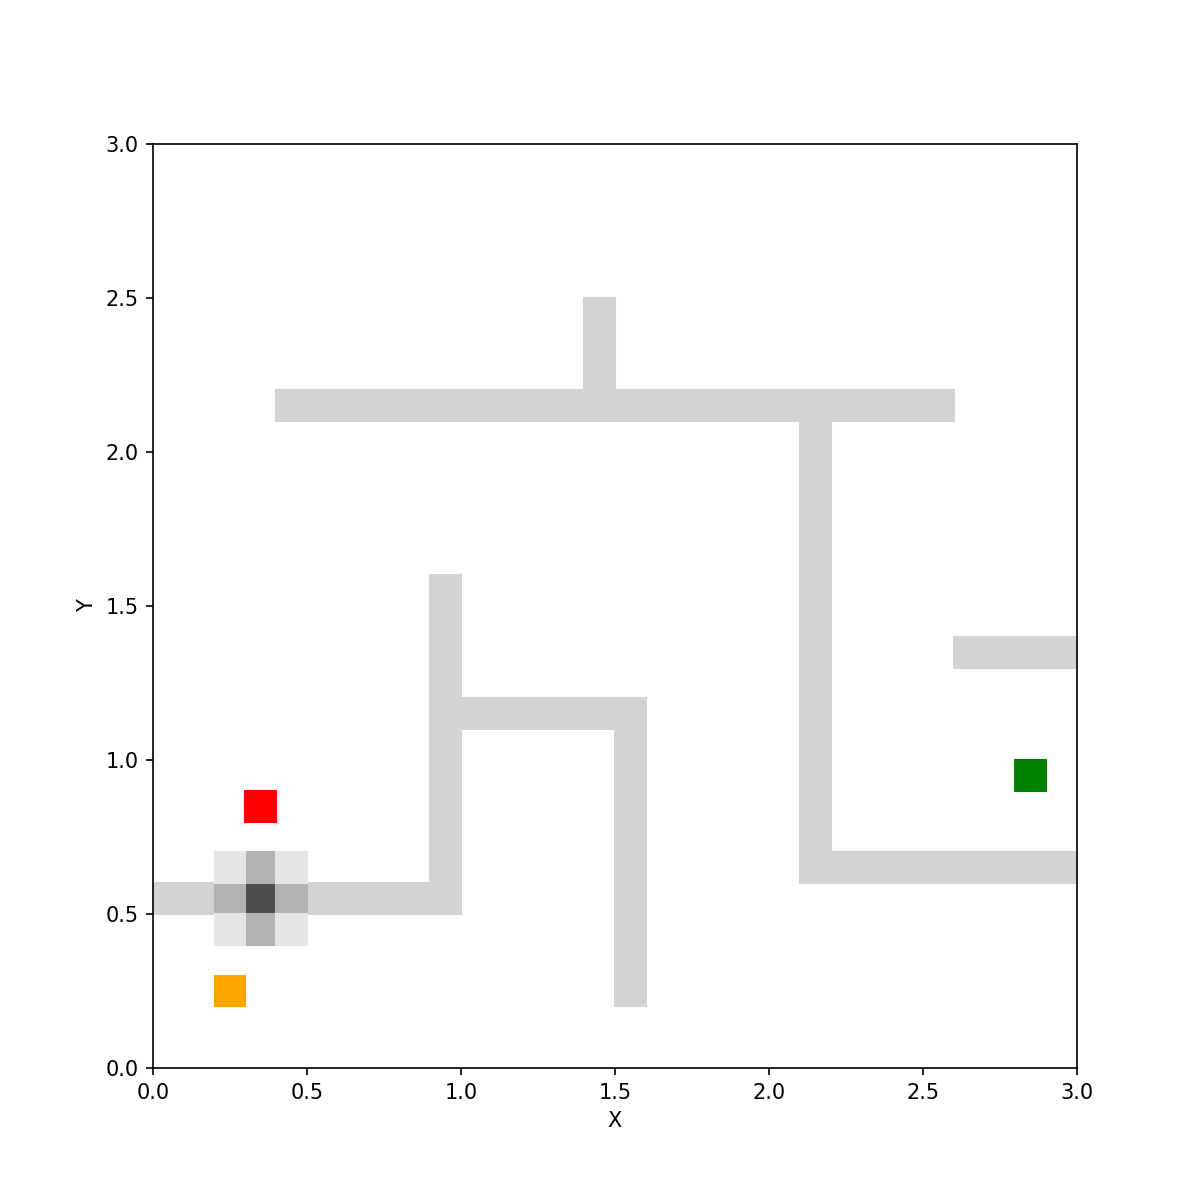

<Figure size 800x800 with 1 Axes>

In [10]:
if __name__ == "__main__":
    time_span = 30
    time_interval = 0.1

    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])

    map_data = "./csvmap/map2.csv"

    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, time_show="time", debug=False)
    sensor = Sensor(world)
    sensor.plot(figsize=(8, 8), robot_index=np.array([3, 8]))